In [2]:
import matplotlib.pyplot as plt
import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data

import os

In [3]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../prediction-dataset/"
os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [4]:
# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

#### Kalman Filter Setup Function

In [5]:
# kalmanFilterSetup() sets up the matrices needed to use the multivariate Kalman Filter
def kalmanFilterSetup():

    # setting up matrices for Kalman Filter
    # initial state matrix, "unknown" vehicle location so we set pos, vel, acc to 0
    x = np.array([[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]])

    # since velocity and acceleration is unknown, a high estimate uncertainty is set, resulting in a high Kalman Gain
    # calculate these values
    P = np.array([[100, 0, 0, 0, 0, 0],
                  [0, 80, 0, 0, 0, 0],
                  [0, 0, 10, 0, 0, 0],
                  [0, 0, 0, 100, 0, 0],
                  [0, 0, 0, 0, 80, 0],
                  [0, 0, 0, 0, 0, 10]])

    # t = measurement period in seconds
    t = 1
    acc_std_dev = 0.2

    # state transition matrix, kinematic equations for position, velocity, and acceleration
    F = np.array([[1, t, 0.5*(t**2), 0, 0,          0], 
                  [0, 1,          t, 0, 0,          0], 
                  [0, 0,          1, 0, 0,          0], 
                  [0, 0,          0, 1, t, 0.5*(t**2)], 
                  [0, 0,          0, 0, 1,          t], 
                  [0, 0,          0, 0, 0,          1]])

    # process noise matrix
    Q = np.array([[0.25, 0.5, 0.5,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0],
                  [   0,   0,   0, 0.25, 0.5, 0.5],
                  [   0,   0,   0,  0.5,   1,   1],
                  [   0,   0,   0,  0.5,   1,   1]]) * (acc_std_dev**2)

    # measurement error variance
    xvar = 30
    yvar = 30
    
    # measurement uncertainty matrix
    R = np.array([[xvar, 0], 
                  [0, yvar]])

    H = np.array([[1, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 1, 0, 0]])

    I = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])

    # initialization
    P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q
    
    return(x, F, P, R, H, Q, I,)

#### Kalman Filter Function

In [6]:
# kalmanFilter() implements the Kalman Filter on the inputted measurements for the given number of iterations
def kalmanFilter(measurements, iterations, output):
    estimates = []
    predictions = []

    x, F, P, R, H, Q, I = kalmanFilterSetup()

    for i in range(iterations):
        z = np.array([[measurements[i][0]],
                      [measurements[i][1]]])
        if output: print(z)
        
        # Kalman Gain calculation
        # K = (P * H_T) * (H * P * H_T + R)^-1
        K = np.matmul(np.matmul(P, np.transpose(H)), 
                      np.linalg.inv(np.matmul(np.matmul(H, P), np.transpose(H)) + R))
        if output: print(K)

        # current state estimation
        # x = x + K * (z - H * x)
        x = x + np.matmul(K, (z - np.matmul(H, x)))
        estimates.append([x[0][0],x[3][0]])
        if output: print(x)

        # update estimate uncertainty
        # P = (I - K * H) * P * (I - K * H)_T + K * R * K_T
        # IKH = (I - K * H)
        IKH = I - np.matmul(K, H)
        P = np.matmul(np.matmul(IKH, P), np.transpose(IKH)) + np.matmul(np.matmul(K, R), np.transpose(K))
        if output: print(P)

        # predict state and update estimate uncertainty
        # x = F * x
        # P = F * P * F_T + Q
        x = np.matmul(F, x)
        P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q 
        predictions.append([x[0][0],x[3][0]])
        if output: print(x)
        if output: print(P)

    # formatting
    estimates = np.array(estimates)
    predictions = np.array(predictions)
    
    return (estimates, predictions)

#### Plotting function

In [7]:
# plotData() plots the measured data, as well as the estimates and predictions from the Kalman Filter, and plots them on a scatter plot

# plot ellipse estimate/prediction covariance
def plotData(measurements, estimates, predictions):
    
    measurements_x = [pos[0] for pos in measurements]
    measurements_y = [pos[1] for pos in measurements]

    estimates_x = [estimate[0] for estimate in estimates]
    estimates_y = [estimate[1] for estimate in estimates]

    predictions_x = [prediction[0] for prediction in predictions]
    predictions_y = [prediction[1] for prediction in predictions]

    fig, ax = plt.subplots()
    ax.scatter(measurements_x, measurements_y, label="measurements", s=10, alpha=0.8)
    ax.scatter(estimates_x, estimates_y, label="estimates", s=8, alpha=0.5)
    ax.scatter(predictions_x, predictions_y, label="predictions", s=8, alpha=0.5)
    ax.legend()
    fig.set_size_inches(10, 5)
    plt.show()

#### Extracting scene indices from the l5kit dataset

In [8]:
scene_frame_indices = []
scene_frame_indices = zarr_dataset.scenes[:]["frame_index_interval"]
# print(scene_frame_indices)

#print(zarr_dataset.frames[slice(0, 248)]["ego_translation"])

#### Mean-squared error

In [9]:
def mse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    return np.square(np.subtract(position, prediction)).mean(axis=0)

#### Weighted mean-squared error

In [10]:
# https://www.geeksforgeeks.org/how-to-implement-weighted-mean-square-error-in-python/#:~:text=Weighted%20mean%20square%20error%20enables,be%20a%20vital%20performance%20metric.
def wmse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    weights = np.array([1/(len(position)-x) for x in range(len(position))])
    weights = weights/weights.sum()
    weights = [[weight, weight] for weight in weights]

    return (np.square(np.subtract(position, prediction))*weights).sum(axis=0)

In [11]:
START_FRAME = 0
END_FRAME = 1
#mse = (1/n) * sum(actual-prediction)^2
mse_values = []
wmse_values = []

for scene in scene_frame_indices:
    positions = []
    #get position of ego vehicle at every frame
    positions = zarr_dataset.frames[slice(scene[START_FRAME], scene[END_FRAME])]["ego_translation"]
    positions = [[pos[0], pos[1]] for pos in positions]

    estimates, predictions = kalmanFilter(measurements=positions, iterations=len(positions), output=False)
    # calculate mean-squared error between measure:estimate and measure:prediction and store values
    mse_values.append([mse(positions, predictions)[0], mse(positions, predictions)[1]])
    wmse_values.append([wmse(positions, predictions)[0], wmse(positions, predictions)[1]])
# print(mse_values, wmse_values)

In [12]:
x_error = [error[0] for error in mse_values]
y_error = [error[1] for error in mse_values]

x_error_w =  [error[0] for error in wmse_values]
y_error_w =  [error[1] for error in wmse_values]

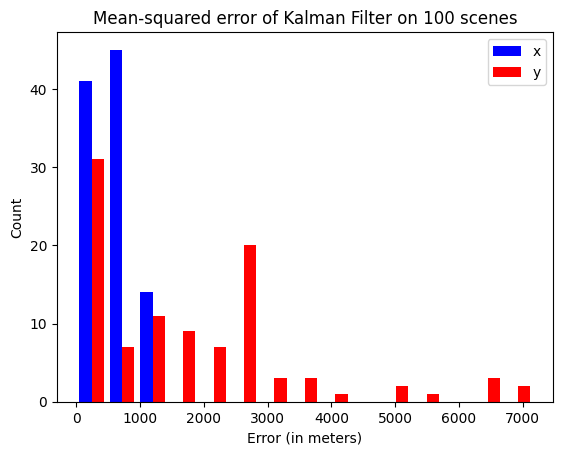

In [13]:
plt.hist([x_error, y_error], label=['x', 'y'], color=['blue', 'red'], bins=15)
plt.legend()
plt.title("Mean-squared error of Kalman Filter on 100 scenes")
plt.xlabel('Error (in meters)')
plt.ylabel('Count')
plt.show()

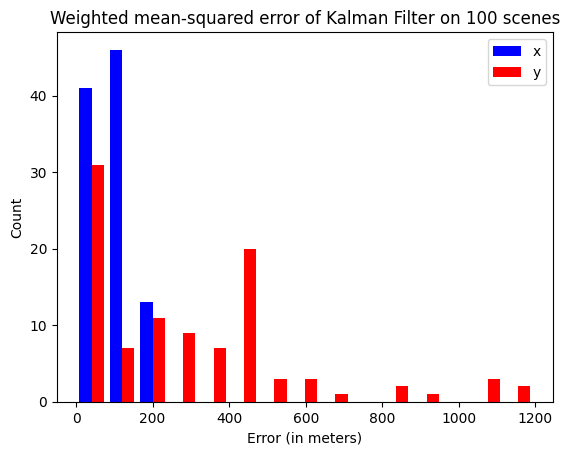

In [14]:
plt.hist([x_error_w, y_error_w], label=['x', 'y'], color=['blue', 'red'], bins=15)
plt.legend()
plt.title("Weighted mean-squared error of Kalman Filter on 100 scenes")
plt.xlabel('Error (in meters)')
plt.ylabel('Count')
plt.show()

#### Optimizing data access 

In [ ]:
# OLD CALCULATION
position_AV = []
for i in range(0, 248):
    position_AV.append([ego_dataset[i]["centroid"][0], ego_dataset[i]["centroid"][1]])

# OPTIMIZED CALCULATION
positions = zarr_dataset.frames[slice(scene[START_FRAME], scene[END_FRAME])]["ego_translation"]
positions = [[pos[0], pos[1]] for pos in positions]

In [ ]:
# OLD
scene_frame_indices = []
for i in range(len(zarr_dataset.scenes)):
    scene_frame_indices.append([zarr_dataset.scenes[i][0][0], zarr_dataset.scenes[i][0][1]])
    
# OPTIMIZED
scene_frame_indices = []
scene_frame_indices = zarr_dataset.scenes[:]["frame_index_interval"]

#### Example: Plotting Kalman Filter of Scene 1

In [ ]:
position_AV = []
for i in range(0, 248):
    position_AV.append([ego_dataset[i]["centroid"][0], ego_dataset[i]["centroid"][1]])

In [ ]:
estimates_AV, predictions_AV = kalmanFilter(measurements=position_AV, iterations=len(position_AV), output=False)

In [ ]:
plotData(measurements=position_AV, estimates=estimates_AV, predictions=predictions_AV)